In [113]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 287.5 kB/s eta 0:00:0000:0100:01


## Import Necessary Libraries:

In [115]:
import pandas as pd
import numpy as np
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

## Step 1: Fetch Historical Stock Data for Palantir (PLTR):

[*********************100%***********************]  1 of 1 completed


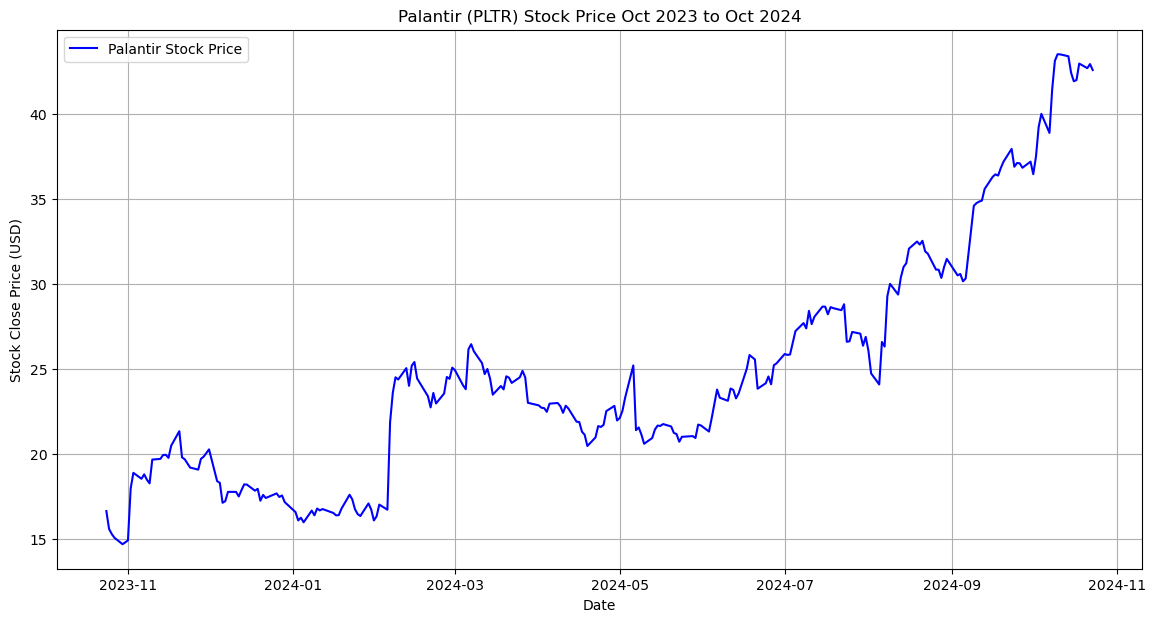

In [119]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

#Step 1: Collect stock price data
# Get historical data for Palantir (PLTR) from Yahoo Finance
stock_data = yf.download("PLTR", start="2023-10-24", end="2024-10-24")
stock_data = stock_data[['Close', 'Volume']]  # Only keep the Close price and volume
stock_data = stock_data.rename(columns={"Close": "Stock_Close"})

# Step 2: Plot the stock price data
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data["Stock_Close"], color="blue", label="Palantir Stock Price")

# Formatting the chart
plt.xlabel("Date")
plt.ylabel("Stock Close Price (USD)")
plt.title("Palantir (PLTR) Stock Price Oct 2023 to Oct 2024")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [127]:
print(stock_data.head(20))

Price      Stock_Close     Volume
Ticker            PLTR       PLTR
2023-10-24   16.639999   39833800
2023-10-25   15.590000   46706500
2023-10-26   15.290000   49351800
2023-10-27   15.070000   39913600
2023-10-30   14.690000   46886400
2023-10-31   14.800000   40195400
2023-11-01   14.920000   54419100
2023-11-02   17.969999  170406800
2023-11-03   18.889999  109039500
2023-11-06   18.540001   79952600
2023-11-07   18.799999   56289100
2023-11-08   18.490000   46063100
2023-11-09   18.270000   48454200
2023-11-10   19.670000   92748000
2023-11-13   19.709999   74877500
2023-11-14   19.940001   83230500
2023-11-15   19.950001   75533500
2023-11-16   19.770000   49942800
2023-11-17   20.490000   69497400
2023-11-20   21.340000   90270000


## Step 2: Pulling reddit post for Palantir (PLTR) via API:

In [233]:
import praw
import pandas as pd
from datetime import datetime

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="l0eUrGuv9ZGfNI6TCNaKOg",
    client_secret="-eGUdmoE6Alj0yXEITngEARaDDrkwA",
    user_agent="SendimentApp/0.1 by Cyn19",
    #username="YOUR_REDDIT_USERNAME",  # Optional, only needed for certain actions
    #password="YOUR_REDDIT_PASSWORD"   # Optional, only needed for certain actions
)

# Define subreddits and date range
subreddits = ["stocks", "PLTR", "investing", "wallstreetbets"]  # List of subreddits to pull from
start_date = datetime(2023, 10, 24)
end_date = datetime(2024, 10, 24)

# Collect posts
posts = []
for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    for submission in subreddit.search("Palantir OR PLTR", limit=1000):
        post_date = datetime.fromtimestamp(submission.created_utc)  # Convert timestamp to datetime
        if start_date <= post_date <= end_date:  # Filter posts within the date range
            posts.append([submission.created_utc, submission.title, submission.selftext])

# Create a DataFrame and convert timestamp to datetime for readability
df = pd.DataFrame(posts, columns=['timestamp', 'title', 'text'])
df['date'] = pd.to_datetime(df['timestamp'], unit='s')  # Convert timestamp to datetime
df['content'] = df['title'] + " " + df['text']  # Combine title and text into 'content'
df = df[['date', 'content']]  # Keep only date, content, and subreddit for tracking

# Display the first 20 results
print(df.head(20))



                  date                                            content
0  2024-02-05 21:55:14  Palantir stock jumps on revenue beat - Palanti...
1  2024-09-10 23:04:09  PLTR - Where would you properly value? I recen...
2  2023-11-02 11:28:35  Palantir earnings show AI traction, while comp...
3  2024-03-06 13:33:31  Palantir unveils OPENAI as one of their custom...
4  2024-05-06 22:27:20  Palantir shares fall 3% on lower-than-expected...
5  2024-02-08 14:51:01  What company will be a household name in the n...
6  2024-10-02 16:19:25  Edgescale and Palantir Edgescale AI Emerges fr...
7  2024-07-26 15:13:55  Short seller Andrew Left of Citron charged wit...
8  2024-01-05 09:18:07  What are your controversial stocks you’ll neve...
9  2024-03-04 19:40:23  Speculative Crap I'm Investing In So You Don't...
10 2024-07-08 21:12:02  Future AI Growth Stock Ideas? What are your th...
11 2024-10-20 21:03:57  I compiled a list of all 190 stocks and funds ...
12 2024-09-20 12:30:23  (9/20) Friday'

In [235]:
num_rows = df.shape[0]
print(f"Number of rows in the DataFrame: {num_rows}")

Number of rows in the DataFrame: 258


## Step 3: Preprocessing for Sendiment Analysis:

In [245]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return " ".join(tokens)

# Apply preprocessing
df['content'] = df['content'].apply(preprocess_text)

print(df.head())

                 date                                            content  \
0 2024-02-05 21:55:14  palantir stock jump revenue beat palantir repo...   
1 2024-09-10 23:04:09  pltr would properly value recently looked pala...   
2 2023-11-02 11:28:35  palantir earnings show ai traction company hit...   
3 2024-03-06 13:33:31  palantir unveils openai one customer xb denver...   
4 2024-05-06 22:27:20  palantir share fall lowerthanexpected guidance...   

   sentiment_score  
0           0.9771  
1           0.8777  
2           0.9927  
3           0.7184  
4           0.9793  


## Step 4: Perform Sentiment Analysis on Reddit Data

In [249]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['sentiment_score'] = df['content'].apply(lambda text: sia.polarity_scores(text)['compound'])

# View the resulting DataFrame with sentiment scores
print(df[['date', 'content', 'sentiment_score']].head())

                 date                                            content  \
0 2024-02-05 21:55:14  palantir stock jump revenue beat palantir repo...   
1 2024-09-10 23:04:09  pltr would properly value recently looked pala...   
2 2023-11-02 11:28:35  palantir earnings show ai traction company hit...   
3 2024-03-06 13:33:31  palantir unveils openai one customer xb denver...   
4 2024-05-06 22:27:20  palantir share fall lowerthanexpected guidance...   

   sentiment_score  
0           0.9771  
1           0.8777  
2           0.9927  
3           0.7184  
4           0.9793  


## Step 5: Merge Stock Data with Reddit Sentiment Data:

In [251]:
import pandas as pd

# Assuming stock_data was imported with an extra header, re-importing or resetting headers could fix it
# If 'Price' row is actually the first row of data, skip this row when reading/importing, or manually remove it

# Resetting headers
if 'Price' in stock_data.columns or 'Ticker' in stock_data.columns:
    stock_data.columns = stock_data.iloc[0]  # Use the first row as header
    stock_data = stock_data[1:]  # Remove the first row, now acting as headers

# Rename columns and reset the index
stock_data.columns = ["date", "Stock_Close", "Volume"]
stock_data.reset_index(drop=True, inplace=True)

# Convert 'date' column to a proper datetime format
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date

# Check the cleaned stock data
print(stock_data.head())

         date  Stock_Close    Volume
0  2023-10-24    16.639999  39833800
1  2023-10-25    15.590000  46706500
2  2023-10-26    15.290000  49351800
3  2023-10-27    15.070000  39913600
4  2023-10-30    14.690000  46886400


In [253]:
# Step 1: Aggregate the Reddit sentiment data by date
# Ensure 'date' is in date-only format (not datetime)
df['date'] = pd.to_datetime(df['date']).dt.date  # Convert to date format (without time)
daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index()

# Step 2: Merge the stock data with the daily sentiment data
# Ensure stock_data also has 'date' in date-only format (if not already done)
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date

# Merge on the 'date' column
merged_data = pd.merge(stock_data, daily_sentiment, on='date', how='left')

# Step 3: Handle any missing sentiment scores (e.g., for dates with no Reddit data)
merged_data['sentiment_score'] = merged_data['sentiment_score'].fillna(0)

# View the merged DataFrame
print(merged_data.head(20))

          date  Stock_Close     Volume  sentiment_score
0   2023-10-24    16.639999   39833800           0.0000
1   2023-10-25    15.590000   46706500           0.0000
2   2023-10-26    15.290000   49351800           0.0000
3   2023-10-27    15.070000   39913600           0.0000
4   2023-10-30    14.690000   46886400           0.0000
5   2023-10-31    14.800000   40195400           0.0000
6   2023-11-01    14.920000   54419100           0.0000
7   2023-11-02    17.969999  170406800           0.9927
8   2023-11-03    18.889999  109039500           0.0000
9   2023-11-06    18.540001   79952600           0.0000
10  2023-11-07    18.799999   56289100          -0.5574
11  2023-11-08    18.490000   46063100           0.0000
12  2023-11-09    18.270000   48454200           0.0000
13  2023-11-10    19.670000   92748000           0.0000
14  2023-11-13    19.709999   74877500           0.0000
15  2023-11-14    19.940001   83230500           0.0000
16  2023-11-15    19.950001   75533500          

## Step 6: Data Preprocessing for LSTM

In [255]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant features for LSTM and scale them
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Stock_Close', 'Volume', 'sentiment_score']])

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # We predict the 'Stock_Close' price
    return np.array(X), np.array(y)

# Create sequences with a sequence length of 60 (e.g., previous 60 days)
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Step 7: Build and Train the LSTM Model

In [257]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for predicting 'Stock_Close'
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0805 - val_loss: 0.0634
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0195 - val_loss: 0.0751
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0093 - val_loss: 0.1672
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0105 - val_loss: 0.1424
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0083 - val_loss: 0.0823
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0086 - val_loss: 0.0555
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088 - val_loss: 0.0809
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0054 - val_loss: 0.0888
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0066 - val_loss: 0.0534
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - val_loss: 0.0392
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0050 - val_loss: 0.0362
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0056 - val_loss: 0.0329
E

## Step 8: Evaluate the Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


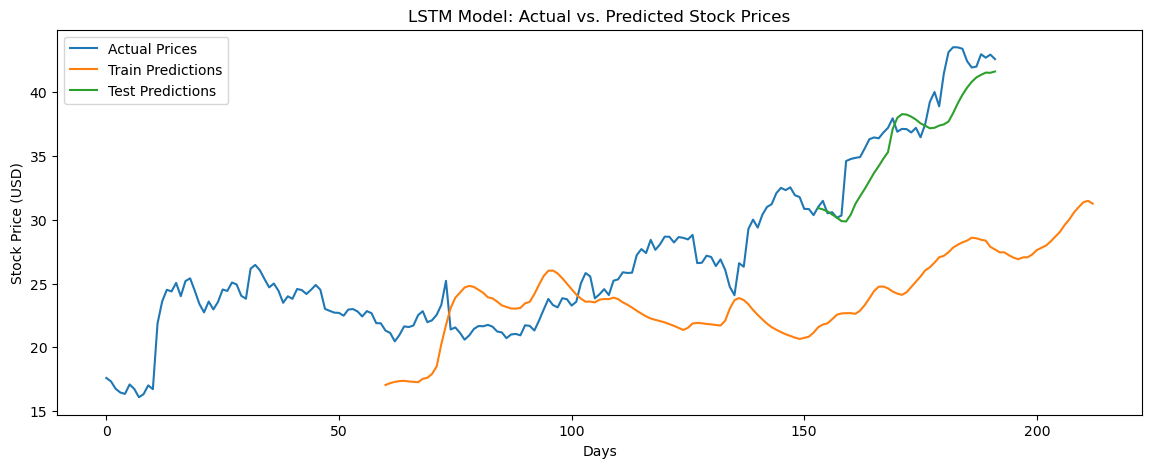

In [259]:
# Predict on training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for interpretability
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 2))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 2))), axis=1))[:,0]
actual_prices = scaler.inverse_transform(np.concatenate((y.reshape(-1, 1), np.zeros((y.shape[0], 2))), axis=1))[:,0]

# Plot the results with axis labels
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(range(sequence_length, len(train_predict) + sequence_length), train_predict, label='Train Predictions')
plt.plot(range(len(actual_prices) - len(test_predict), len(actual_prices)), test_predict, label='Test Predictions')
plt.xlabel('Days')  # X-axis label
plt.ylabel('Stock Price (USD)')  # Y-axis label
plt.title('LSTM Model: Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [261]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Train MAE: 23.578197900094377
Test MAE: 35.2164016147997


## Step 9: Making Future Predictions

In [263]:
import pandas as pd

# Ensure that the 'date' column in merged_data is in datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')

# Check for any NaT (Not a Time) values in the 'date' column, which could cause issues
if merged_data['date'].isnull().any():
    print("Warning: There are invalid dates in the data.")
    print(merged_data[merged_data['date'].isnull()])

# Set 'date' as the index if not already done
merged_data.set_index('date', inplace=True)

# Now try to get the last date
last_date = merged_data.index[-1]
print(f"Last date in data: {last_date}")

Last date in data: 2024-10-23 00:00:00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

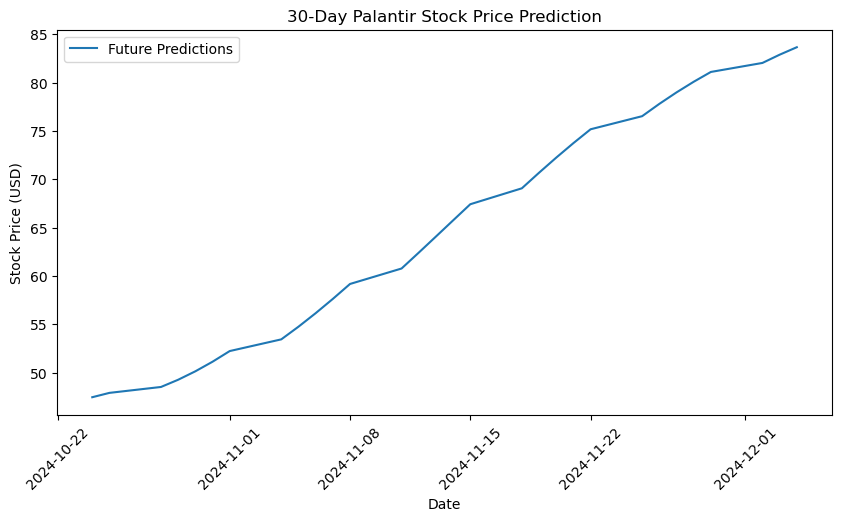

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

def predict_future(data, model, steps=30):
    predictions = []
    last_sequence = data[-sequence_length:]
    for _ in range(steps):
        pred = model.predict(last_sequence[np.newaxis, :, :])[0][0]
        predictions.append(pred)
        last_sequence = np.append(last_sequence[1:], [[pred, 0, 0]], axis=0)
    return predictions

# Predict the next 30 days
future_predictions = predict_future(scaled_data, model)

# Reverse scale for interpretability
future_predictions = scaler.inverse_transform(np.concatenate((np.array(future_predictions).reshape(-1,1), np.zeros((len(future_predictions), 2))), axis=1))[:,0]

# Extract the last date from merged_data
last_date = pd.to_datetime(merged_data.index[-1])
print(f"Last date in data: {last_date}")  # Debugging: print last_date

# Generate 30 future business dates starting from the day after the last date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')
print(f"Future dates: {future_dates}")  # Debugging: print future_dates

# Plot the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.title('30-Day Palantir Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.show()

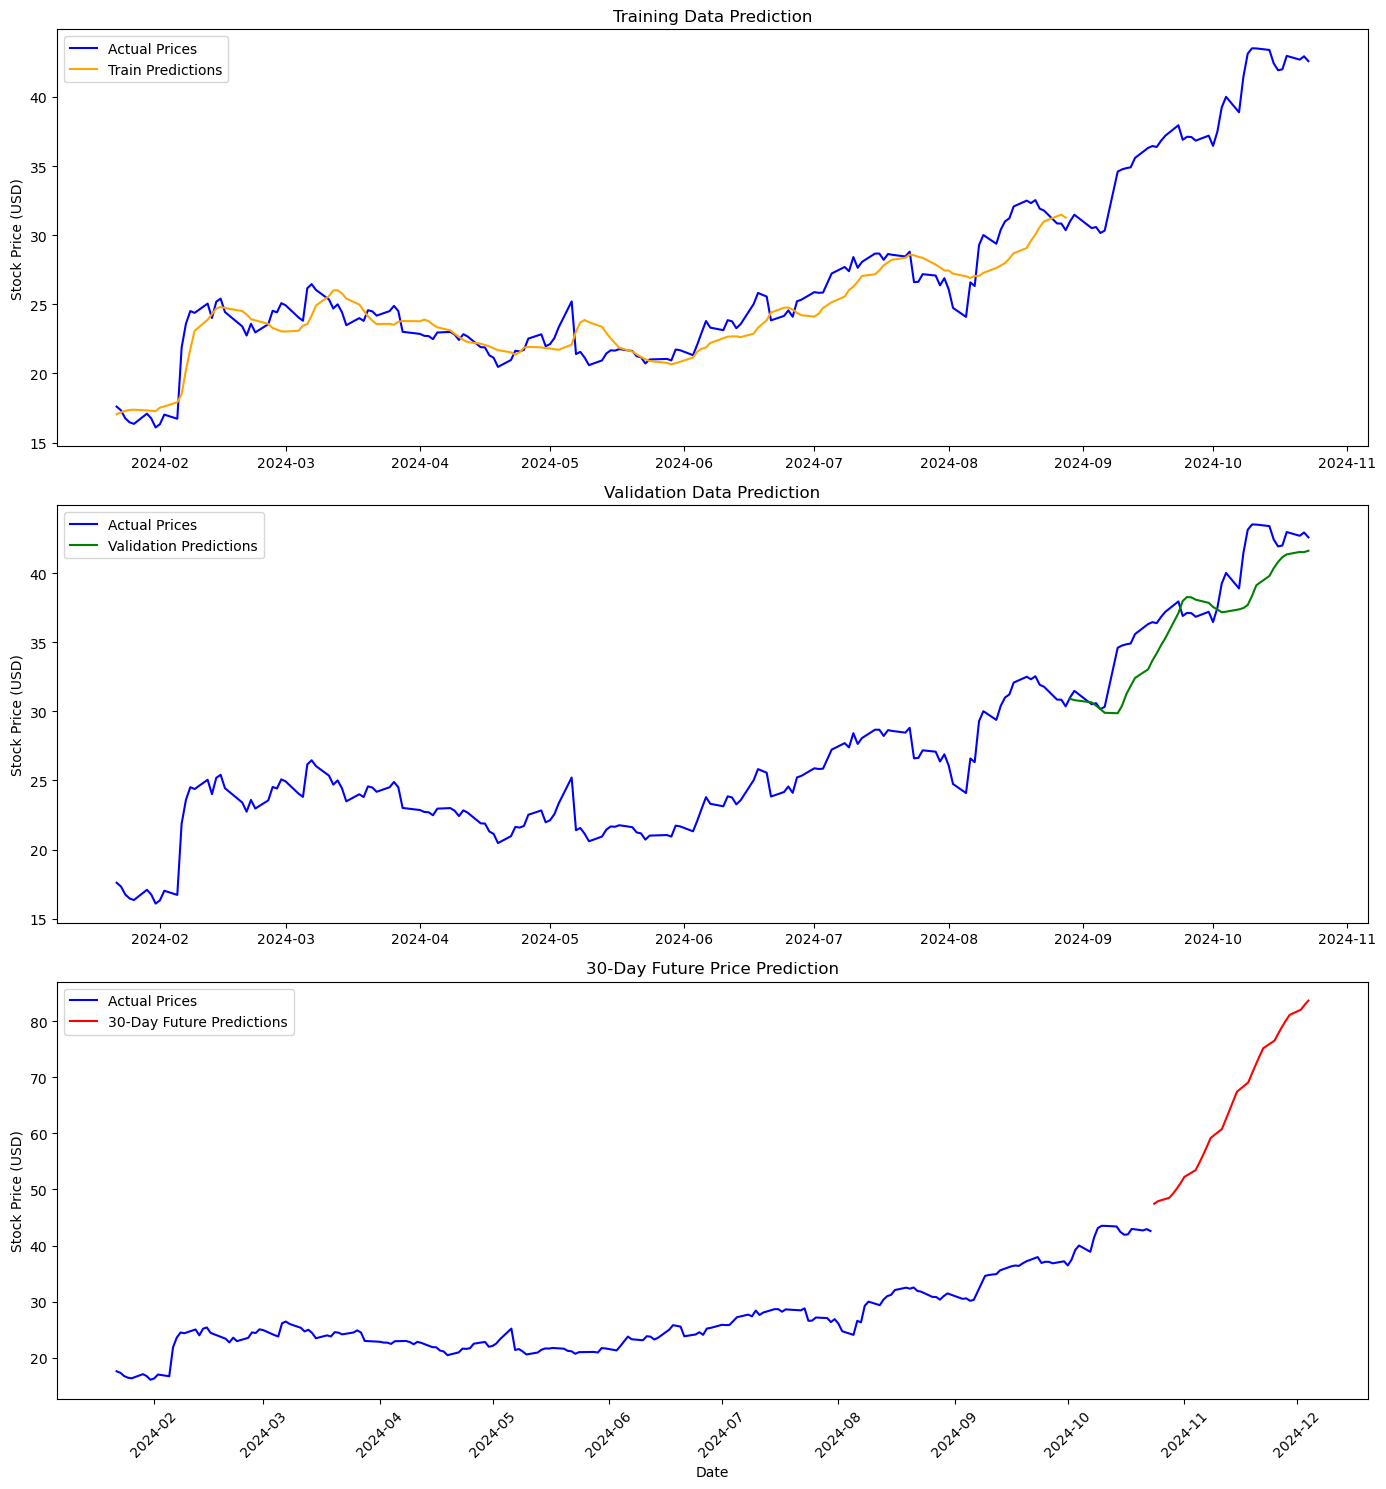

In [265]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Adjusting the dates to align with actual_prices
aligned_dates = dates[sequence_length:]  # Adjust dates to match the actual_prices length

# Split dates for train, test, and future predictions
train_dates = aligned_dates[:len(train_predict)]
val_dates = aligned_dates[len(train_predict):len(train_predict) + len(test_predict)]
future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=len(future_predictions), freq='B')

# Plot the results
fig, axs = plt.subplots(3, 1, figsize=(14, 15))  # Adjust for multiple subplots

# Plot the actual and training predictions
axs[0].plot(aligned_dates, actual_prices, label="Actual Prices", color='blue')
axs[0].plot(train_dates, train_predict, label="Train Predictions", color='orange')
axs[0].set_title("Training Data Prediction")
axs[0].set_ylabel("Stock Price (USD)")
axs[0].legend()

# Plot the validation predictions
axs[1].plot(aligned_dates, actual_prices, label="Actual Prices", color='blue')
axs[1].plot(val_dates, test_predict, label="Validation Predictions", color='green')
axs[1].set_title("Validation Data Prediction")
axs[1].set_ylabel("Stock Price (USD)")
axs[1].legend()

# Plot the future predictions
axs[2].plot(aligned_dates, actual_prices, label="Actual Prices", color='blue')
axs[2].plot(future_dates, future_predictions, label="30-Day Future Predictions", color='red')
axs[2].set_title("30-Day Future Price Prediction")
axs[2].set_ylabel("Stock Price (USD)")
axs[2].legend()

# Common x-axis label and adjustments
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [283]:
import pandas as pd

# Define the target date
target_date = pd.to_datetime("2024-11-12")

# Check if the target date is in future_dates
if target_date in future_dates:
    # Find the index of the target date
    target_index = future_dates.get_loc(target_date)
    # Retrieve the predicted price for that date
    predicted_price = future_predictions[target_index]
    print(f"The predicted price for Palantir on 12 November 2024 is: ${predicted_price:.2f}")
else:
    print("The date 12 November 2024 is not within the range of predicted future dates.")

The predicted price for Palantir on 12 November 2024 is: $62.41


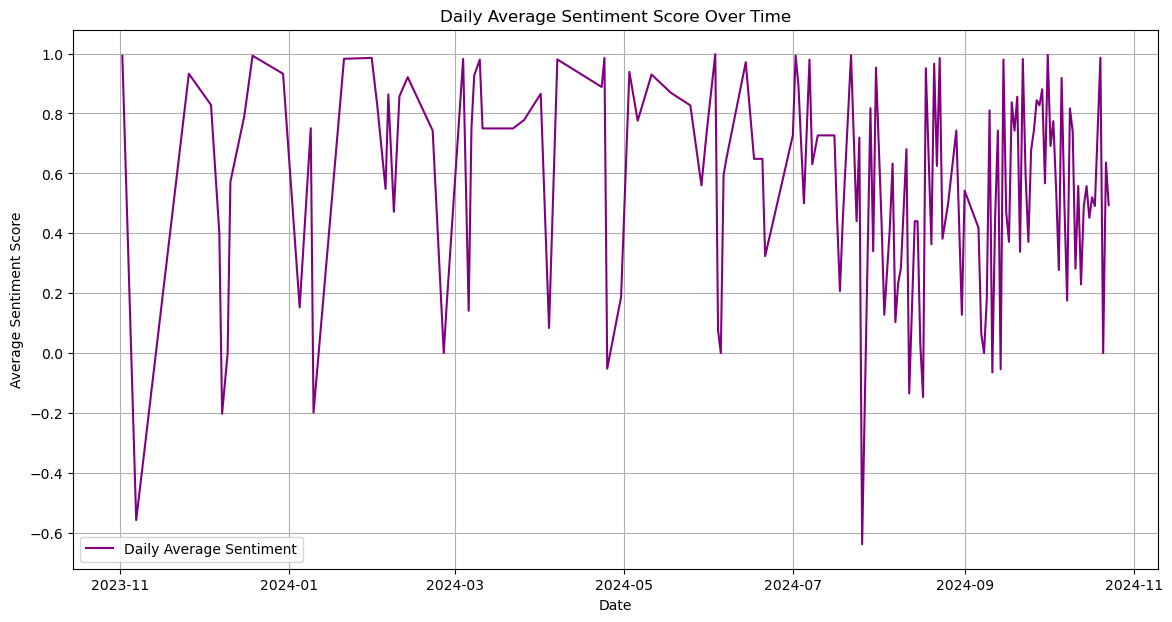

In [269]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `df` is your dataframe with sentiment scores and dates

# Calculate daily average sentiment
daily_sentiment = df.groupby('date')['sentiment_score'].mean()

# Plot daily average sentiment over time
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment.index, daily_sentiment.values, color='purple', label='Daily Average Sentiment')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Daily Average Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [271]:
# Summary statistics for sentiment scores
sentiment_summary = df['sentiment_score'].describe()
print(sentiment_summary)

# Additional statistics if needed
median_sentiment = df['sentiment_score'].median()
std_dev_sentiment = df['sentiment_score'].std()
print(f"Median Sentiment: {median_sentiment}")
print(f"Standard Deviation: {std_dev_sentiment}")

count    258.000000
mean       0.518109
std        0.445558
min       -0.927400
25%        0.151100
50%        0.726900
75%        0.908325
max        0.999700
Name: sentiment_score, dtype: float64
Median Sentiment: 0.7269
Standard Deviation: 0.44555805348492655


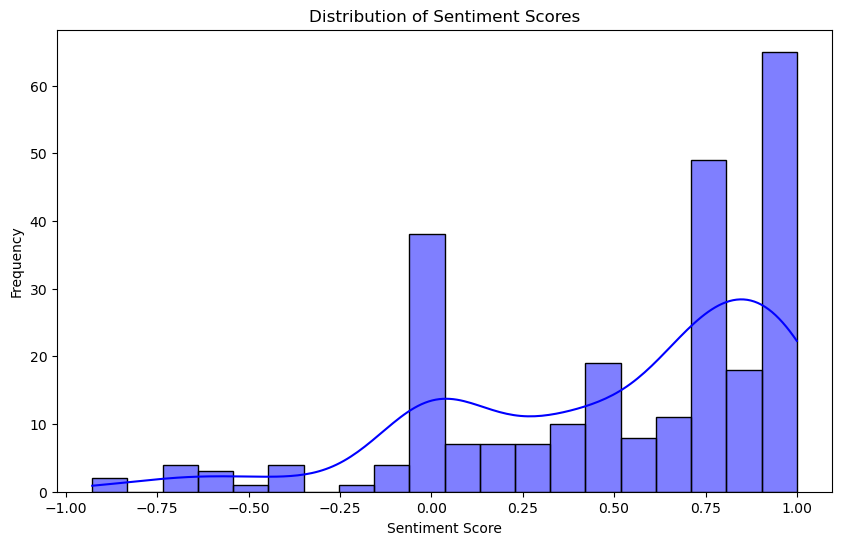

In [273]:
import seaborn as sns

# Distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], bins=20, kde=True, color='blue')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

Correlation between sentiment score and stock price: 0.4219859268906889


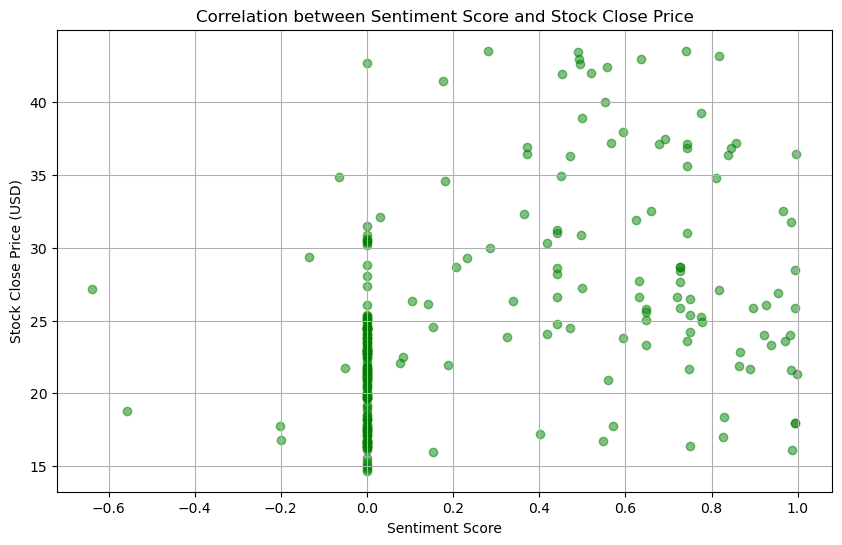

In [275]:
# Correlation between sentiment score and stock closing price
correlation = merged_data['sentiment_score'].corr(merged_data['Stock_Close'])
print(f"Correlation between sentiment score and stock price: {correlation}")

# Plotting stock price vs. sentiment score to visualize any relationship
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['sentiment_score'], merged_data['Stock_Close'], alpha=0.5, color='green')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Close Price (USD)')
plt.title('Correlation between Sentiment Score and Stock Close Price')
plt.grid(True)
plt.show()